

```
Overview

*   Get an under powered car to the top of a hill (top = 0.5 in position)
*   Car starts at random position from -0.6 to -0.4 with no velocity
*   -1 towards reward for each time step, until the car reaches the goal position
*   There are two states (position and velocity) and three actions (left, none, or right).
```



In [1]:
%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from collections import deque
from keras import Sequential, models
from keras.layers import Dense
from keras.optimizers import adam
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


Construct agent

In [0]:
class DQN():

    """ Implementation of deep q learning algorithm"""

    def __init__(self):

        """
        Initalize an Agent object
        """

        self.action_space = env.action_space.n
        self.state_space = env.observation_space.shape[0]
        self.epsilon = 1
        self.epsilon_min = .001
        self.epsilon_decay = .995
        self.discount_factor = 0.9
        self.learning_rate = 0.001
        self.batch_size = 128
        self.memory = deque(maxlen = 10000)
        self.model = self.build_model()

    def build_model(self):

        """
        The model is based on a convolutional neural network. It is trying to predict 
        the return of taking each action given the state of the current environment.
        """

        model = Sequential()
        model.add(Dense(24, input_shape = (self.state_space,), activation = 'relu'))
        model.add(Dense(24, activation = 'relu'))
        model.add(Dense(self.action_space, activation = 'linear'))
        model.compile(loss = 'mse', optimizer = adam(lr = self.learning_rate))
        return model

    def save_model(self, filename = None):

        self.model.save(filename)

    def remember(self, state, action, reward, next_state, done):

        """
        Save the memory that the agent observes and we will use this data later
        """ 

        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        """
        To balance between exploration and exploitation, a epsilon-greedy policy is 
        introduced. It is a decaying probability percentage which the learning algorithm
        uses to choose between. picking random action (exploration) or greedy action 
        based on existing knowledge (exploitation).
        """

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        if random.uniform(0, 1) <= self.epsilon: # exploration
            return env.action_space.sample()
        else:
            act_values = self.model.predict(state) # exploitation
            return np.argmax(act_values[0])

    def replay(self):
        
        """
        Agent experiences replay memory during training. Replay memory will be 
        selected randomly, so that a batch of tranining samples are decorrelted. 
        """
      
        # Wait until we have enough sample available in memeory
        if len(self.memory) < self.batch_size: 
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        # Q function is updated based on Bellman Equation
        states, next_states = np.squeeze(states), np.squeeze(next_states)
        targets = rewards + self.discount_factor * (np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets 

        self.model.fit(states, targets_full, epochs = 1, verbose = 0)

    def total_energy(self, state):
        """
        We will use total energy to make the reward function for reinforcement learning. 
        Total energy is the sum of its motion (i.e. kinetic energy) and the result 
        of its stored energy of position (i.e. potential energy).
        """
        x = state[0, 0] # position in x direction
        v = state[0, 1] # velocity

        # A change of the height is given by dh = dx cos φx, 
        # which integrates to hx = 0.0025 / g * cos(3x)dx = 0.0025 / (3g) * sin(3x) + C
        # Here we will use g = 1, and C = 0
        potential_energy = 0.0025 / 3 * (math.sin(3 * x)) 
        kinetic_energy = 0.5 * (v ** 2)

        return potential_energy + kinetic_energy

Train agent

episode: 0/75, score: -200
episode: 1/75, score: -173
episode: 2/75, score: -114
episode: 3/75, score: -111
episode: 4/75, score: -114
episode: 5/75, score: -114
episode: 6/75, score: -151
episode: 7/75, score: -117
episode: 8/75, score: -113
episode: 9/75, score: -130
episode: 10/75, score: -140
episode: 11/75, score: -118
episode: 12/75, score: -117
episode: 13/75, score: -123
episode: 14/75, score: -116
episode: 15/75, score: -112
episode: 16/75, score: -111
episode: 17/75, score: -117
episode: 18/75, score: -116
episode: 19/75, score: -112
episode: 20/75, score: -113
episode: 21/75, score: -112
episode: 22/75, score: -112
episode: 23/75, score: -113
episode: 24/75, score: -112
episode: 25/75, score: -113
episode: 26/75, score: -112
episode: 27/75, score: -112
episode: 28/75, score: -113
episode: 29/75, score: -113
episode: 30/75, score: -112
episode: 31/75, score: -112
episode: 32/75, score: -111
episode: 33/75, score: -111
episode: 34/75, score: -111
episode: 35/75, score: -110
ep

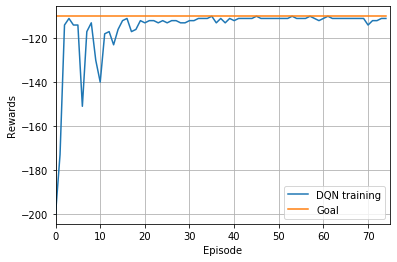

In [3]:
def train_dqn(episode):
    """
    Train dqn model to interact with and learn from the environment
    """
    loss = []
    agent = DQN() 
    goal = 0.5
  
    for e in range(episode):
        env.seed(episode)
        state = env.reset()
        state = np.reshape(state, (1, 2))
        score = 0
        max_steps = 200
        for i in range(max_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, (1, 2))
            score = score -1
            reward = 1000 * (agent.total_energy(next_state) - agent.total_energy(state)) 
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()

            # The episode is done when the agent reaches the goal or 200 steps
            if done: 
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        env.close()
        loss.append(score)

    agent.save_model(filename = 'MountainCar-v0-dqn.h5')
    return loss

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    ep = 75
    loss = train_dqn(ep)

    ### Visualize the process of training dqn model
    plt.subplots(figsize= (6, 4))
    plt.plot(list(range(len(loss))), loss, label = 'DQN training')
    plt.plot(list(range(len(loss))), np.ones((len(loss), 1))* -110, label = 'Goal')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.legend(loc = 'lower right')
    plt.xlim(0, len(loss))
    plt.grid(True)
    plt.show()

Test

In [4]:
def test_dqn(episode):

    """
    Valide dqn model with 100 trials
    """
  
    episodes = episode
    scores = []

    for e in range(episodes):
        state = env.reset()
        score = 0
        while True:
            action = np.argmax(model.predict(np.array([state])))
            state, reward, done, _ = env.step(action)
            score += reward
            if done:
                scores.append(score)
                break
        env.close()
    return np.average(scores)

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    model = models.load_model('MountainCar-v0-dqn.h5')
    ep = 100
    loss = test_dqn(ep)
    print('Average rewards in the last 100 episodes: {}'.format(loss))

Average rewards in the last 100 episodes: -108.14
